In [1]:
import gc
import time
import umap
import collections
import numpy as np
import pandas as pd
import scanpy as sc

import torch
import torch.nn.functional as F

from SMILE import littleSMILE
from SMILE import ReferenceSMILE_trainer

from sklearn.preprocessing import StandardScaler

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

10X multiome PBMC

In [2]:
##Read reference data
file = "F:/10X_PBMC_rna.h5ad"
ref_rna = sc.read_h5ad(file)
ref_rna.obs['source']='RNA-seq'
ref_rna.obs['use']='reference'

file = "F:/10X_PBMC_atac.h5ad"
ref_dna = sc.read_h5ad(file)
ref_dna.obs['use']='reference'

Human hematopoiesis (Granja et al., Nature Biotechnology 2019)

In [3]:
##Read query data
file = "E:/h5ad/Granja_PBMC_rna.h5ad"
query_rna = sc.read_h5ad(file)
query_rna.obs['source']='RNA-seq'
query_rna.obs['use']='query'

file = "E:/h5ad/Granja_PBMC_atac.h5ad"
query_dna = sc.read_h5ad(file)
query_dna.obs['use']='query'

sc.pp.normalize_total(query_dna, target_sum=1e4)
sc.pp.log1p(query_dna)

filtered= []
for i in query_rna.obs['cell_type'].values:
    if "_Unk" not in i:
        filtered.append(True)
    else:
        filtered.append(False)
filtered = np.array(filtered)
query_rna = query_rna[filtered]

filtered= []
for i in query_dna.obs['cell_type'].values:
    if "_Unk" not in i:
        filtered.append(True)
    else:
        filtered.append(False)
filtered = np.array(filtered)
query_dna = query_dna[filtered]

In [4]:
##Renaming cell types for better visualization
cells = np.array(query_rna.obs['cell_type'].values)
cells[cells=='05_CMP.LMPP'] = 'CMP'
cells[cells=='08_GMP.Neut'] = 'GMP'
cells[cells=='15_CLP.2'] = 'CLP'


cells[cells=='01_HSC'] = 'HSC'
cells[cells=='06_CLP.1'] = 'CLP'
cells[cells=='06_CLP.2'] = 'CLP'

cells[cells=='02_Early.Eryth'] = 'Eryth'
cells[cells=='07_GMP'] = 'GMP'
cells[cells=='09_pDC'] = 'pDC'

cells[cells=='04_Early.Baso'] = 'Baso'
cells[cells=='03_Late.Eryth'] = 'Eryth'
cells[cells=='17_B'] = 'B'

cells[cells=='12_CD14.Mono.2'] = 'CD14.Mono'
cells[cells=='16_Pre.B'] = 'Pre.B'
cells[cells=='10_cDC'] = 'cDC'

cells[cells=='11_CD14.Mono.1'] = 'CD14.Mono'
cells[cells=='25_NK'] = 'NK'
cells[cells=='21_CD4.N2'] = 'CD4'

cells[cells=='22_CD4.M'] = 'CD4'
cells[cells=='23_CD8.EM'] = 'CD8'
cells[cells=='19_CD8.N'] = 'CD8'

cells[cells=='20_CD4.N1'] = 'CD4'
cells[cells=='24_CD8.CM'] = 'CD8'
cells[cells=='13_CD16.Mono'] = 'CD16.Mono'
cells[cells=='18_Plasma'] = 'Plasma'
query_rna.obs['cell_type']=cells

##--------------------------------------------------
cells = np.array(query_dna.obs['cell_type'].values)
cells[cells=='05_CMP.LMPP'] = 'CMP'
cells[cells=='08_GMP.Neut'] = 'GMP'
cells[cells=='15_CLP.2'] = 'CLP'


cells[cells=='01_HSC'] = 'HSC'
cells[cells=='06_CLP.1'] = 'CLP'
cells[cells=='06_CLP.2'] = 'CLP'

cells[cells=='02_Early.Eryth'] = 'Eryth'
cells[cells=='07_GMP'] = 'GMP'
cells[cells=='09_pDC'] = 'pDC'

cells[cells=='04_Early.Baso'] = 'Baso'
cells[cells=='03_Late.Eryth'] = 'Eryth'
cells[cells=='17_B'] = 'B'

cells[cells=='12_CD14.Mono.2'] = 'CD14.Mono'
cells[cells=='16_Pre.B'] = 'Pre.B'
cells[cells=='10_cDC'] = 'cDC'

cells[cells=='11_CD14.Mono.1'] = 'CD14.Mono'
cells[cells=='25_NK'] = 'NK'
cells[cells=='21_CD4.N2'] = 'CD4'

cells[cells=='22_CD4.M'] = 'CD4'
cells[cells=='23_CD8.EM'] = 'CD8'
cells[cells=='19_CD8.N'] = 'CD8'

cells[cells=='20_CD4.N1'] = 'CD4'
cells[cells=='24_CD8.CM'] = 'CD8'
cells[cells=='13_CD16.Mono'] = 'CD16.Mono'
cells[cells=='18_Plasma'] = 'Plasma'
cells[0]='CD16.Mono'
query_dna.obs['cell_type']=cells

Trying to set attribute `.obs` of view, copying.
Trying to set attribute `.obs` of view, copying.


In [5]:
##identify highly variable features across modalities
adata = ref_rna.concatenate(query_rna,query_dna)

sc.pp.highly_variable_genes(ref_rna, n_top_genes=5000,subset=True)
adata_rna = ref_rna.concatenate(query_rna)

sc.pp.highly_variable_genes(ref_dna, n_top_genes=5000,subset=True)
adata_dna = ref_dna.concatenate(query_dna)

print('total uique cells: '+str(adata.X.shape[0]))
print('# of features in RNA-seq:' + str(adata_rna.X.shape[1]))
print('# of features in ATAC-seq:' + str(adata_dna.X.shape[1]))

total uique cells: 89672
# of features in RNA-seq:3989
# of features in ATAC-seq:3663


In [6]:
##Scale data
X_rna_paired = adata_rna[adata_rna.obs['use']=='reference'].X.todense()
X_dna_paired = adata_dna[adata_dna.obs['use']=='reference'].X.todense()
X_rna_unpaired = adata_rna[adata_rna.obs['use']=='query'].X.todense()
X_dna_unpaired = adata_dna[adata_dna.obs['use']=='query'].X.todense()

scaler = StandardScaler()
X_rna_paired = scaler.fit_transform(X_rna_paired)

scaler = StandardScaler()
X_dna_paired = scaler.fit_transform(X_dna_paired)

scaler = StandardScaler()
X_rna_unpaired = scaler.fit_transform(X_rna_unpaired)

scaler = StandardScaler()
X_dna_unpaired = scaler.fit_transform(X_dna_unpaired)

In [7]:
start_time = time.time()

integrater = littleSMILE(input_dim_a=X_rna_paired.shape[1],input_dim_b=X_dna_paired.shape[1],clf_out=20)
ReferenceSMILE_trainer(X_rna_paired,X_dna_paired,X_rna_unpaired,X_dna_unpaired,integrater,train_epoch=1000)

print("--- %s seconds ---" % int((time.time() - start_time)))

--- 296 seconds ---


In [9]:
integrater.to(torch.device("cpu"))
integrater.eval()
X_tensor_A=torch.tensor(X_rna_paired).float()
X_tensor_B=torch.tensor(X_dna_paired).float()
X_tensor_uA=torch.tensor(X_rna_unpaired).float()
X_tensor_uB=torch.tensor(X_dna_unpaired).float()

z_a=integrater.encoder_a(X_tensor_A)
z_b=integrater.encoder_b(X_tensor_B)
z_ua=integrater.encoder_a(X_tensor_uA)
z_ub=integrater.encoder_b(X_tensor_uB)

z_a = F.normalize(z_a, dim=1,p=2)
z_b = F.normalize(z_b, dim=1,p=2)
z_a = torch.Tensor.cpu(z_a).detach().numpy()
z_b = torch.Tensor.cpu(z_b).detach().numpy()

z_ua = F.normalize(z_ua, dim=1,p=2)
z_ub = F.normalize(z_ub, dim=1,p=2)
z_ua = torch.Tensor.cpu(z_ua).detach().numpy()
z_ub = torch.Tensor.cpu(z_ub).detach().numpy()

y_pred = np.concatenate(((z_a+z_b)/2,z_ua,z_ub),0)
umaps = umap.UMAP(n_neighbors=10, min_dist=0.1, n_components=2,
                  metric="correlation").fit(y_pred)

embedding = umaps.transform(y_pred)
adata.obsm['X_umap']=embedding

... storing 'cell_type' as categorical
... storing 'source' as categorical
... storing 'use' as categorical


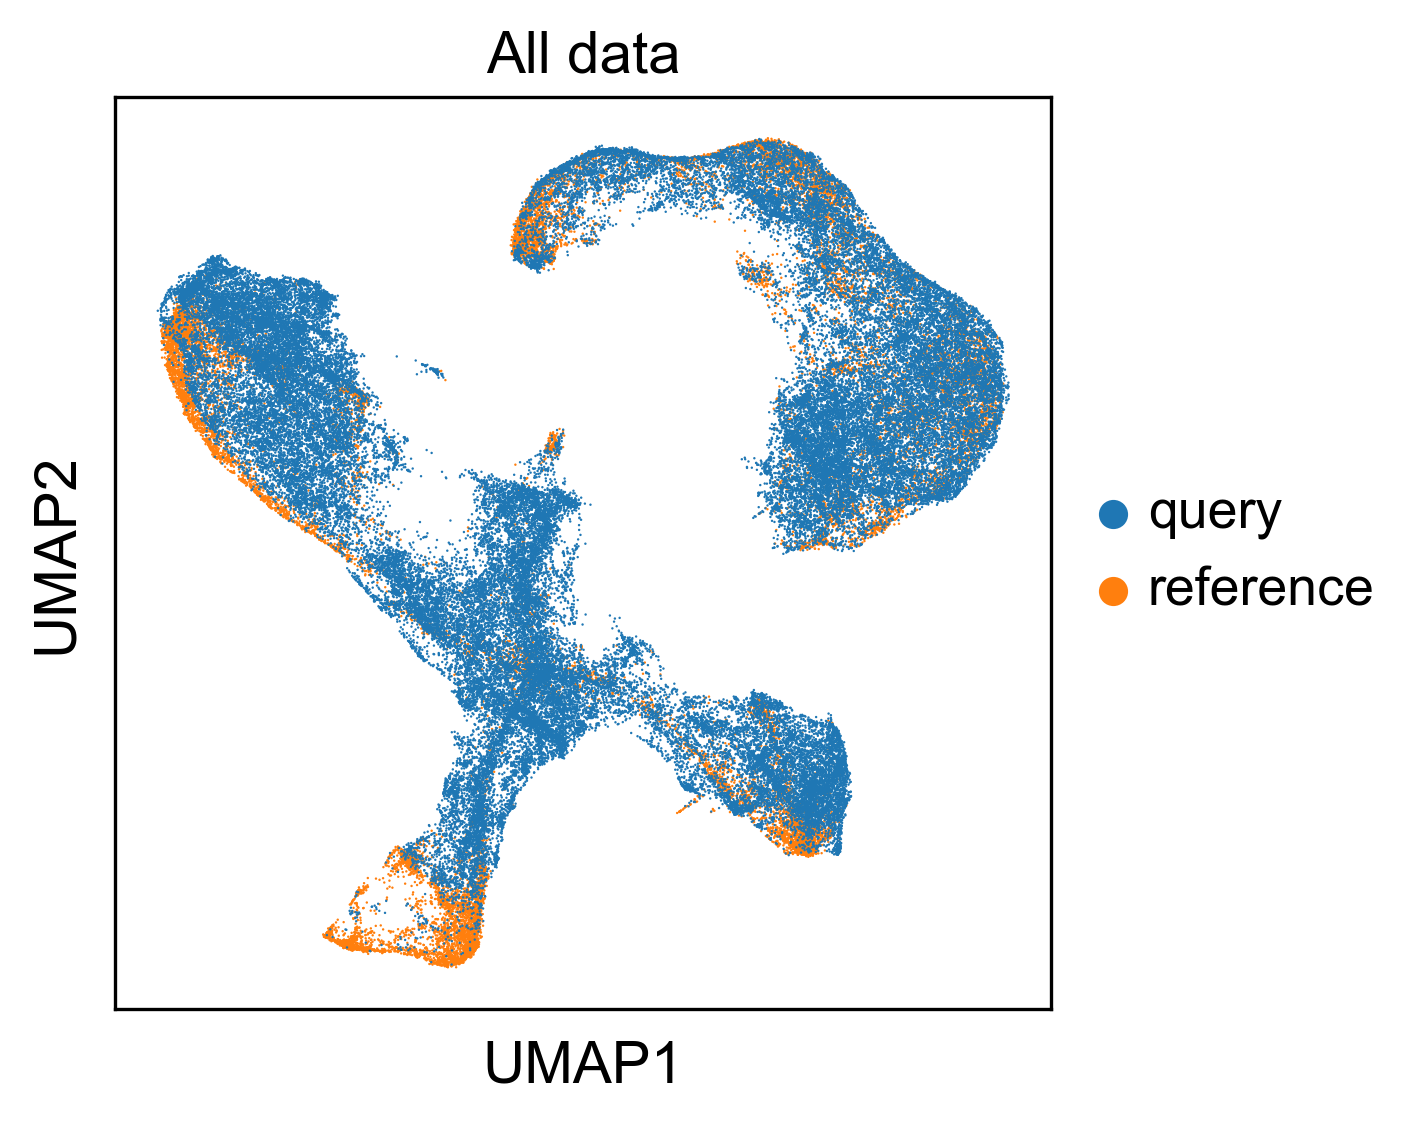

In [10]:
##Visualization of integration outcome
sc.set_figure_params(scanpy=True, dpi=150, dpi_save=150)
sc.pl.umap(adata, color='use', title='All data')

Trying to set attribute `._uns` of view, copying.


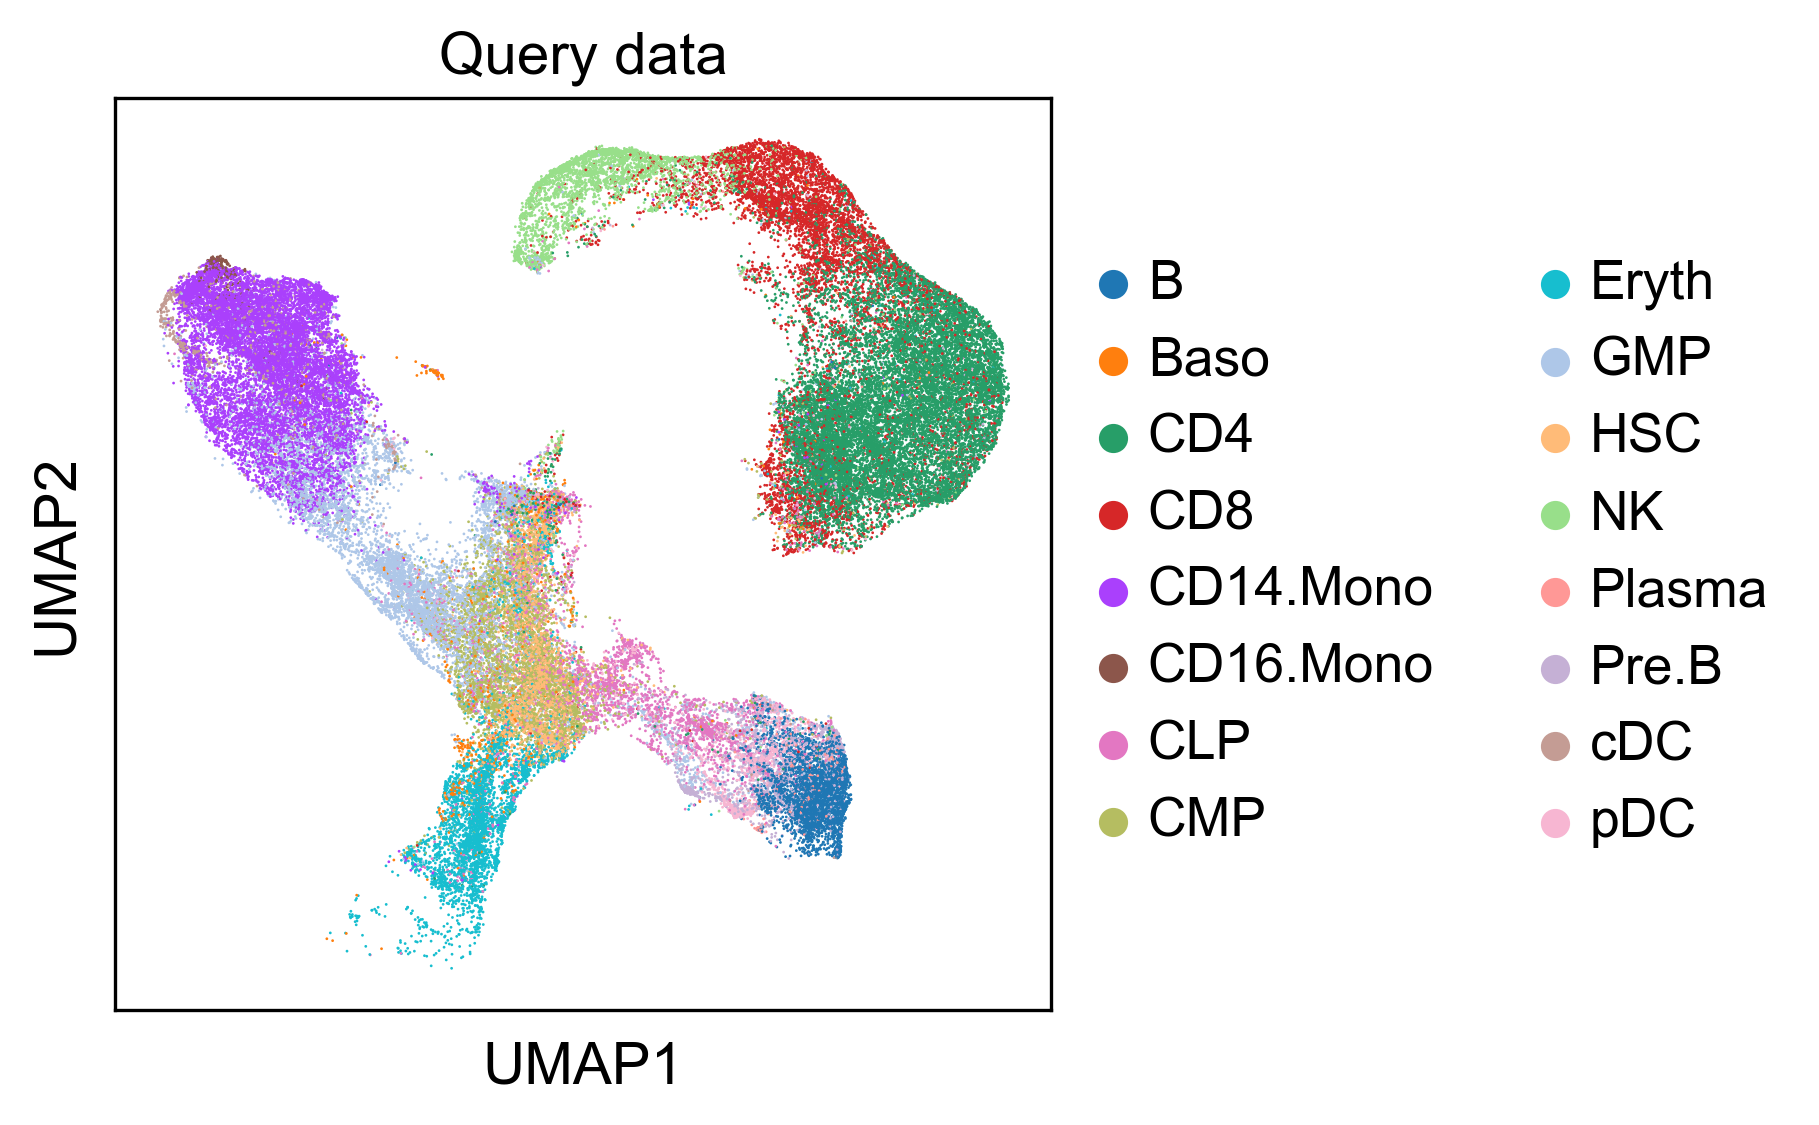

Trying to set attribute `._uns` of view, copying.


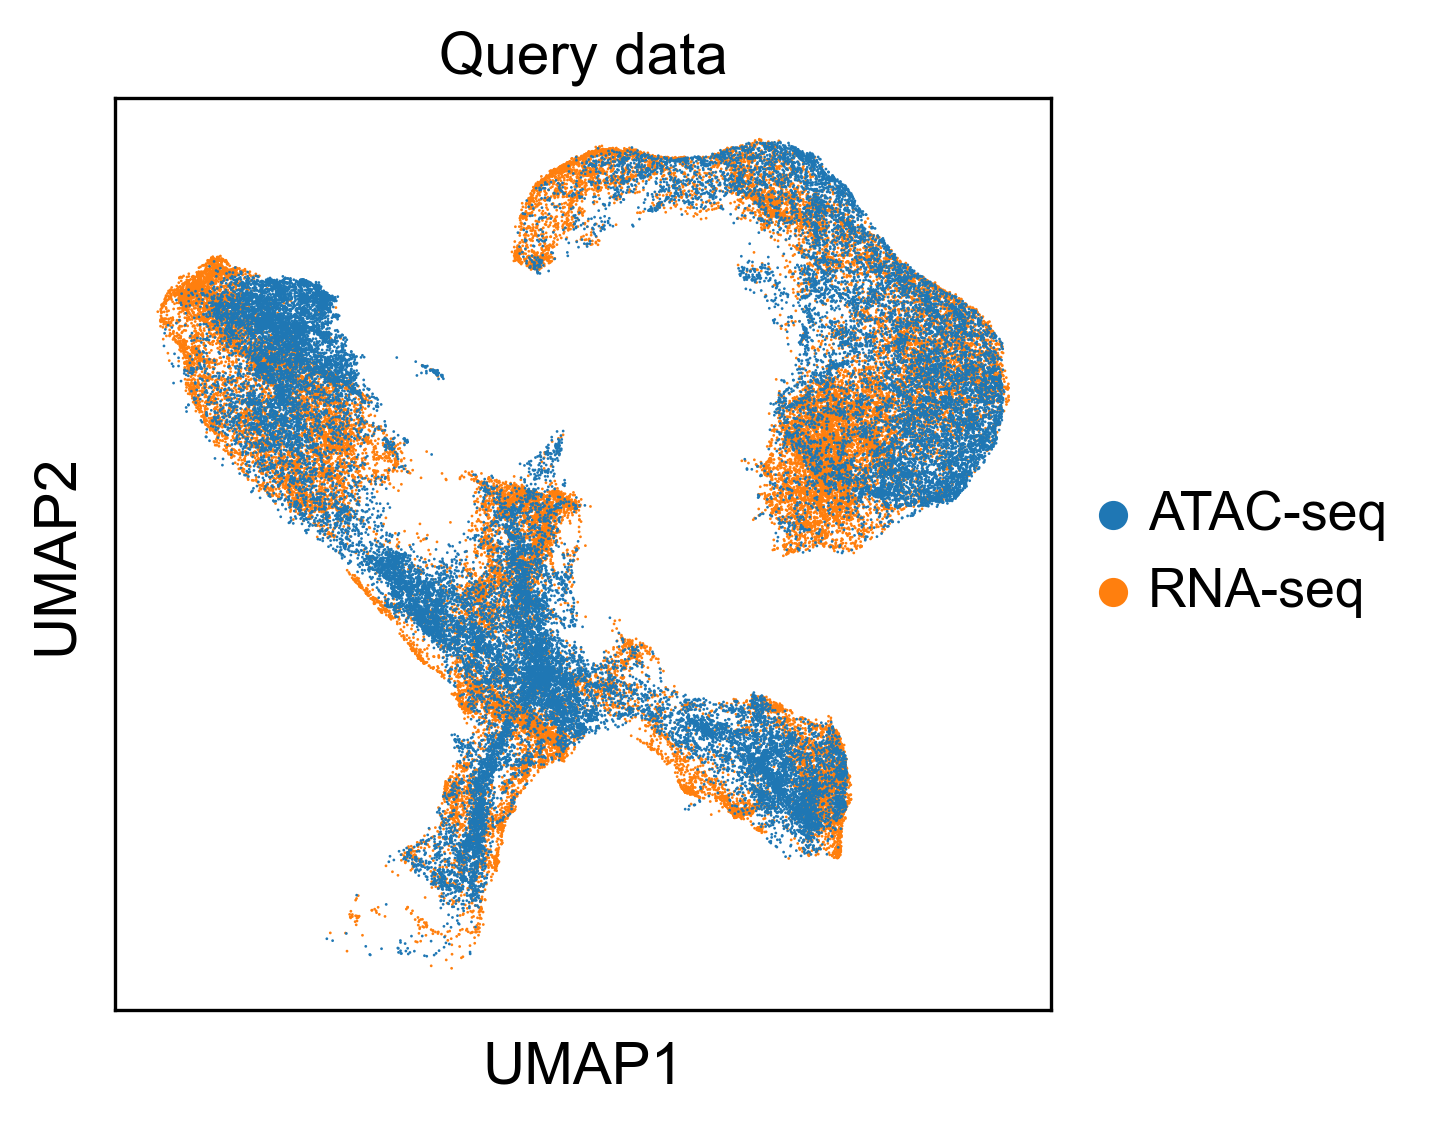

In [11]:
sc.pl.umap(adata[adata.obs['use']=='query'], color='cell_type', title='Query data')
sc.pl.umap(adata[adata.obs['use']=='query'], color='source', title='Query data')